# 1. Preparing the Dataset

<span style="color:red">This notebook uses three additional libraries called imblearn,xgboost and ipywidget. Kindly install, as it is used in the Ensemble Model Building</span>

<span style="color:red">A couple of Grid Search cells are set to markdown mode as they take extremely long time. These are marked with CAUTION!!! label. To execute them, the assessor must set them to Code. These cells can be skipped and the note book would still run.__</span>

We import the relevant libraries as usual and upload the csv data into our dataframe __df__. The first step we take is to eliminate rows where recharge amount was 0 in both months 6 and 7. We do this,because these samples would errorneously pull down our average calculation.

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

df1=pd.read_csv('telecom_churn_data.csv')

In [2]:
df=df1[~((df1['total_rech_amt_6']==0) & (df1['total_rech_amt_7']==0))]

In [3]:
df.shape

(96724, 226)

### 1.1 Labelling the Classes

Now that we have only non-zero values in total_rech_amt_6 and 7 , we calculate the 70th Percentile of the average of these two columns and call it __high_val_thd__ .<br>
We retain only those rows, where the average of these two columns is greater than or equal to the threshold.

In [4]:
high_val_thd=((df['total_rech_amt_6']+df['total_rech_amt_7'])/2).quantile(0.7)
df=df[((df['total_rech_amt_6']+df['total_rech_amt_7'])/2)>=high_val_thd]

The function __find_churn__ returns 1 if incoming/outgoing calls and 2G/3G Data is 0 for the month 9, else it reurns 0. The values returned are kept in a new column called __churn__

0    26530
1     2504
Name: churn, dtype: int64


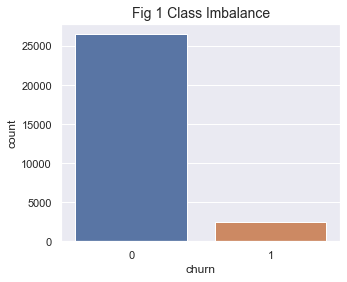

In [5]:

def find_churn(x):
    mou= x.total_ic_mou_9+x.total_og_mou_9+x.vol_2g_mb_9+x.vol_3g_mb_9
    if mou==0:
        y=1
    else:
        y=0
    return y

df['churn']=df.apply(find_churn,axis=1)
print(df['churn'].value_counts())
fig1, ax1 = plt.subplots(figsize=(5, 4))
ax1.set_title('Fig 1 Class Imbalance', fontsize=14)
ax1 = sns.countplot(x="churn", data=df)

Straight up, we see that there's a data imbalance. Churn cases is merely 10% of non-curn cases. Overall churn rate is at 8.6%.

### 1.2 Removing Irrelevant Columns

As stated in the guidelines, we can now remove all columns with the ___9__ suffix. <br>
The columns Mobile Number and Circle ID are also irrelevant.<br>
There is one feature __Volume Based Charging 3G__ from Jun to September. Since we are supposed to get rid of Sept ( Month 9 ) data, we remove __sep_vbc_3g__ as well 


In [6]:
cols_with_9=[ i for i in df.columns if i.find('_9')!=-1]
df.drop(cols_with_9,inplace=True,axis=1)
df.drop(['mobile_number', 'circle_id','sep_vbc_3g'],inplace=True,axis=1)

In [7]:
df.shape

(29034, 170)

## 2 EDA

We are now in a position to assess the percentage of missing value in the dataframe. In the next cell , we present the percent of missing values only for columns that have missing entries.

In [8]:
mis_vals=df.isna().sum()!=0
(round(100*df.isna().sum()/29034,2))[mis_vals]

loc_og_t2o_mou               0.39
std_og_t2o_mou               0.39
loc_ic_t2o_mou               0.39
last_date_of_month_7         0.11
last_date_of_month_8         0.53
onnet_mou_6                  1.06
onnet_mou_7                  1.02
onnet_mou_8                  3.13
offnet_mou_6                 1.06
offnet_mou_7                 1.02
offnet_mou_8                 3.13
roam_ic_mou_6                1.06
roam_ic_mou_7                1.02
roam_ic_mou_8                3.13
roam_og_mou_6                1.06
roam_og_mou_7                1.02
roam_og_mou_8                3.13
loc_og_t2t_mou_6             1.06
loc_og_t2t_mou_7             1.02
loc_og_t2t_mou_8             3.13
loc_og_t2m_mou_6             1.06
loc_og_t2m_mou_7             1.02
loc_og_t2m_mou_8             3.13
loc_og_t2f_mou_6             1.06
loc_og_t2f_mou_7             1.02
loc_og_t2f_mou_8             3.13
loc_og_t2c_mou_6             1.06
loc_og_t2c_mou_7             1.02
loc_og_t2c_mou_8             3.13
loc_og_mou_6  

### 2.1 Derived Feature MOU

There are 90 variables related to MOU ( Minutes of Usage ) with the following characteritics.<br>

- The MOU for __T to O__ is either 0 or missing for all rows, irrespective of incoming/outgoing or STD calls.
- Then there are 29 MOU variables , one each for the months 6,7 and 8
- We will use some domain research to establish the relationship with them. 

In [9]:
# Calls from Operator T to Other operator fixed line is either 0 or missing !!
# So we might as well delete them, but let us check all the t2o mou features.

t_2_o=['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou']
for i in t_2_o:
    print(df[i].value_counts())

0.0    28920
Name: loc_og_t2o_mou, dtype: int64
0.0    28920
Name: std_og_t2o_mou, dtype: int64
0.0    28920
Name: loc_ic_t2o_mou, dtype: int64


On further study , we notice that for outgoing calls , the local and std are sum of few components.<br>

$ loc\_og\_t2t + loc\_og\_t2m + loc\_og\_t2f = loc\_og\_mou  $ <br>
$ std\_og\_t2t + std\_og\_t2m + std\_og\_t2f + std\_og\_t2c = std\_og\_mou  $ <br>
$ loc\_og\_mou + std\_og\_mou + spl\_o\_mou + isd\_og\_mou + og\_others = total\_og\_mou $

Similarly , for incoming calls

$ loc\_ic\_t2t + loc\_ic\_t2m + loc\_ic\_t2f = loc\_ic\_mou $ <br>
$ std\_ic\_t2t + std\_ic\_t2m + std\_ic\_t2f + std\_ic\_t2o = std\_ic\_mou $ <br>
$ loc\_ic\_mou + std\_ic\_mou + spl\_ic\_mou + isd\_ic\_mou + ic\_others = total\_ic\_mou $ <br>

This means , there's some multi-collinearity inbuilt in the features. We can get rid of the following features as their totals are available in the right hand side of the equations above<br>
- t2t,t2m,t2f for local incoming and outgoing calls.
- t2t,t2m,t2f,t2o,t2c for std incoming and outgoing calls.
- if we keep the total MOU for Incoming, Outgoing, STD, Special, ISD and Others, then we do not need to retain total_og_mou and total_ic_mou 

In [10]:
x=['og_t2t','og_t2m','og_t2f','og_t2o','ic_t2t','ic_t2m',
   'ic_t2f','ic_t2o','std_og_t2c','std_og_t2o','total_og_mou','total_ic_mou']

# if any columns contain the sub-strings in the list above, we append them to our
# list del_mou, then we delete these columns.

del_mou=[]
for col in df.columns:
    if any(c in col for c in x):
        del_mou.append(col)

df.drop(del_mou,inplace=True,axis=1)

There's one ominous feature __t2c__ referring calls to Customer Care. We'll retain __loc_og_t2c_mou__ as this may indicate customer frustration, if they make too many calls of this category in the __action__ period.<br>

We will now prepare a list of the mou features that we retained. We also need to add incoming and outgoing __others__ to our list of mou features. <br>

We will now replace all missing values with 0, signifying zero minutes of usage for the coresponding feature.

In [11]:
mou_cols=[i for i in df.columns if i.find('mou')>-1 or i.find('others')>-1]
df.fillna({x:0 for x in mou_cols}, inplace=True)

In [12]:
n=len(mou_cols)

At this stage we have a list of __Minutes of Usage__ features for month 6,7 and 8. The variable __n__ holds its length. For every mou ( incoming, outgoing, std, local etc ), we'll take the average of month 6-7 and calculate percentage increase/decrease in month 8. This will give us a sense of sharp increase or decrease of the mou.

For Example <br>
$ xi = mean ( onnet\_mou\_6,onnet\_mou\_7) $ <br>
$ xf = onnet\_mou\_8 $ <br>
$ delta = xf - xi $ <br>
$ onnet\_mou = \frac { delta } {xi} $ <br>

We repeat the same process for all mou features ( indicated below ). However, we also deal with division by 0 or 0/0 in the function declaration.


In [13]:
def cal_delta(row,*args):
    xi=(row[args[0]]+row[args[1]])/2
    xf=row[args[2]]
    delta=xf-xi
    
    if xi!=0 and delta!=0:
        return delta/xi
    
    # deal with division by 0
    elif xi==0 and delta!=0:
        return 1
    
    # deal with 0 divided by 0 
    elif xi==0 and delta==0:
        return 0
    
    else:
        return delta/xi
    
printmd("***Our New MOU Features***")
for a in range(0,n,3):
    col_name=mou_cols[a][:-2]
    print(col_name)
    
    df[col_name]=df.apply(cal_delta,args=(mou_cols[a],mou_cols[a+1],mou_cols[a+2]),axis=1)

# We do not need the original mou features now

df.drop(mou_cols,inplace=True,axis=1)

***Our New MOU Features***

onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2c_mou
loc_og_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others


### 2.2 Derived Feature from Data Volume

Turning our attention to the data usage in 2G and 3G to explore if there is any sharp decline in data usage from month 6-7 to month 8.<br>
Before that , we check , if there are any missing data !!

In [14]:
# This is a list of features having 2G and 3G data usage in Megabytes
data_vols=['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']

# Are there any missing values ??
df[data_vols].isna().sum()

vol_2g_mb_6    0
vol_2g_mb_7    0
vol_2g_mb_8    0
vol_3g_mb_6    0
vol_3g_mb_7    0
vol_3g_mb_8    0
dtype: int64

There is another caveat ,in terms of data usage. There are users , who haven't used data at all in the 3 months. For such users the difference of usage from months 6-7 to month 8 will always be zero. So ,we introduce another fetaure __Data_User__ , that is set to 0 or 1 depending upon the subscriber being a data user or not. This feature may turn out to be useful when we attempt a decision tree.

In [15]:
# A temporary column Temp having the sum of 2G and 3G data Volume
df['Temp']=df[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']].sum(axis=1)

# The function returns 0 if the total data volume in months 6,7,8 is zero.
def data_user(row):
    x=row['Temp']
    if x==0:
        return 0
    else:
        return 1

df['Data_User']=df.apply(data_user,axis=1)
df.drop('Temp',axis=1,inplace=True)

In [16]:
# Derived Features vol_2g_mb and vol_3g_mb

df['vol_2g_mb']=df.apply(cal_delta,args=('vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'),axis=1)
df.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],inplace=True,axis=1)

df['vol_3g_mb']=df.apply(cal_delta,args=('vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'),axis=1)
df.drop(['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],inplace=True,axis=1)

Having dealt with the data volume __2G and 3G__ features, we notice that the corresponding data arpu features will always be zero , when data volume is zero for that month. <br>

The converse may not be true. Thus, all missing values for arpu 2G and 3G can be replaced by 0. Furthermore , we derive two features arpu_3G and arpu_2g which are difference of the month 8 and mean of month 6-7

In [17]:
# A list of arpu 2G and 3G Features and then fill missing values with 0.

arpu_3g=['arpu_3g_6','arpu_3g_7','arpu_3g_8']
df.fillna({x:0 for x in arpu_3g}, inplace=True)
arpu_2g=['arpu_2g_6','arpu_2g_7','arpu_2g_8']
df.fillna({x:0 for x in arpu_2g}, inplace=True)

# Derived Features arpu_2g and arpu_3g
df['arpu_3g']=df.apply(cal_delta,args=('arpu_3g_6','arpu_3g_7','arpu_3g_8'),axis=1)
df.drop(['arpu_3g_6','arpu_3g_7','arpu_3g_8'],inplace=True,axis=1)

df['arpu_2g']=df.apply(cal_delta,args=('arpu_2g_6','arpu_2g_7','arpu_2g_8'),axis=1)
df.drop(['arpu_2g_6','arpu_2g_7','arpu_2g_8'],inplace=True,axis=1)

### 2.3 Derived Feature Data Recharge Patterns

We now look at the data recharge patterns. Note that:

$ total\_rech\_data = count\_rech\_3g + count\_rech\_2g $

We cam delete the features on the right hand side of the equation and use only __total_rech_data__. <br>

These features indicate, how many times did the customer perform a recharge. We also have the average recharge amount per month. Thus, if we multiply the __total_rech_data__ with __av_rech_amt_data__ , we should get the total recharge amount for data in a particular month.

$ total\_rech\_data\_amt\_6 = total\_rech\_data\_6 * av\_rech\_amt\_data\_6 $

We do this , for months 7 and 8. Then we use the same method as above to check if month 8 shows sharp degradation from average of 6 and 7 or not.

In [18]:
# We calculate the recharge amount in each month
df['total_rech_data_amt_6']=df['total_rech_data_6']*df['av_rech_amt_data_6']
df['total_rech_data_amt_7']=df['total_rech_data_7']*df['av_rech_amt_data_7']
df['total_rech_data_amt_8']=df['total_rech_data_8']*df['av_rech_amt_data_8']

# This creates a feature total_rech_data_amt, which detects any sudden change from mean of
# month 6 and 7 to month 8

df['total_rech_data_amt']=df.apply(cal_delta,args=('total_rech_data_amt_6','total_rech_data_amt_7','total_rech_data_amt_8'),axis=1)


In [19]:
data_rech_cols=['total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8','total_rech_data_amt_6','total_rech_data_amt_7','total_rech_data_amt_8']

df['total_rech_data_amt'].fillna(0,inplace=True)
df.drop(data_rech_cols,axis=1,inplace=True)

### 2.4 Derived Feature Recharge and ARPU

We will now use the same argument to derive features pertaining to Recharge and ARPU. The key idea is to derive a feature that captures any sudden increase/decrease in the feature in month 8 compared to month 6 & 7. 

In [20]:
# Derived Feature arpu

df['arpu']=df.apply(cal_delta,args=('arpu_6','arpu_7','arpu_8'),axis=1)
df.drop(['arpu_6','arpu_7','arpu_8'],inplace=True,axis=1)

# Derived Feature total_rech_num
df['total_rech_num']=df.apply(cal_delta,args=('total_rech_num_6','total_rech_num_7','total_rech_num_8'),axis=1)
df.drop(['total_rech_num_6','total_rech_num_7','total_rech_num_8'],inplace=True,axis=1)

# Derived Feature total_rech_amt
df['total_rech_amt']=df.apply(cal_delta,args=('total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'),axis=1)
df.drop(['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'],inplace=True,axis=1)

# Derived Feature max_rech_amt
df['max_rech_amt']=df.apply(cal_delta,args=('max_rech_amt_6','max_rech_amt_7','max_rech_amt_8'),axis=1)
df.drop(['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8'],inplace=True,axis=1)

# Derived Feature last_day_rch_amt
df['last_day_rch_amt']=df.apply(cal_delta,args=('last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8'),axis=1)
df.drop(['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8'],inplace=True,axis=1)

### 2.5 Derived Feature Data  Packs

There are few features reated to different packs that customer can buy like Night Packs, Monthly 2G/3G, Sachet and Facebook packs.

We will add all these feature packs for a given month and then detect any sharp change from month 6-7 to month 8.

In [21]:
# Replace package features missing values by 0

pack_cols=['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']
df.fillna({x:0 for x in pack_cols}, inplace=True)

In [22]:
# The feature_pack_6 , 7 and 8 is a measure of any package bought in the respective month

df['feature_pack_6']=df['night_pck_user_6']+df['monthly_2g_6']+df['sachet_2g_6']+df['monthly_3g_6']+df['sachet_3g_6']+df['fb_user_6']
df['feature_pack_7']=df['night_pck_user_7']+df['monthly_2g_7']+df['sachet_2g_7']+df['monthly_3g_7']+df['sachet_3g_7']+df['fb_user_7']
df['feature_pack_8']=df['night_pck_user_8']+df['monthly_2g_8']+df['sachet_2g_8']+df['monthly_3g_8']+df['sachet_3g_6']+df['fb_user_8']

# Now we calculate the change in feature_packs in month 8 w.r.t to mean of month 6 and 7
df['feature_pack']=df.apply(cal_delta,args=('feature_pack_6','feature_pack_7','feature_pack_8'),axis=1)

rem_pak_cols=['night_pck_user_6','night_pck_user_7','night_pck_user_8','monthly_2g_6','monthly_2g_7',
              'monthly_2g_8','sachet_2g_6','sachet_2g_7','sachet_2g_8','monthly_3g_6','monthly_3g_7',
              'monthly_3g_8','sachet_3g_6','sachet_3g_7','sachet_3g_8','fb_user_6','fb_user_7','fb_user_8',
              'feature_pack_6','feature_pack_7','feature_pack_8']

df.drop(rem_pak_cols,inplace=True,axis=1)

### 2.6 Derived Feature Recharge Urgency

We try to build a feature indicating whether the subscriber recharged in all three months or not. We provide weights 1,2and 3 to features __date_of_last_rech_6,7 & 8__. We build a feature called __Recharge Habit__, which is a sum of all three weights.<br>

If an individual has re-charged in all three months, then the new feature has a value 1+2+3 = 6. We follow the same approach for __date_of_last_rech_data_6,7 & 8__ and build a  feature __Recharge Habit data__.<br>

With these two features, we can delete the last recharge date columns

In [23]:
mask=df['date_of_last_rech_6'].isna()
df['date_of_last_rech_6'][~mask]=1

mask=df['date_of_last_rech_7'].isna()
df['date_of_last_rech_7'][~mask]=2

mask=df['date_of_last_rech_8'].isna()
df['date_of_last_rech_8'][~mask]=3

pack_cols=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
df.fillna({x:0 for x in pack_cols}, inplace=True)

df['Recharge Habit']=df['date_of_last_rech_6']+df['date_of_last_rech_7']+df['date_of_last_rech_8']

In [24]:
mask=df['date_of_last_rech_data_6'].isna()
df['date_of_last_rech_data_6'][~mask]=1

mask=df['date_of_last_rech_data_7'].isna()
df['date_of_last_rech_data_7'][~mask]=2

mask=df['date_of_last_rech_data_8'].isna()
df['date_of_last_rech_data_8'][~mask]=3

pack_cols=['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
df.fillna({x:0 for x in pack_cols}, inplace=True)

df['Recharge Habit data']=df['date_of_last_rech_data_6']+df['date_of_last_rech_data_7']+df['date_of_last_rech_data_8']

df.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6',
        'date_of_last_rech_data_7','date_of_last_rech_data_8','last_date_of_month_6','last_date_of_month_7',
        'last_date_of_month_8'],axis=1,inplace=True)

### 2.7 Derived Feature Volume Based Charging

This is the last derived feature for __VBC_3G__. Just like we did above, we take the mean of months 6 and 7 and subtarct it from month 8. Our new feature is __vbc_3g__ 

In [25]:
vbc_cols=['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g']
df.fillna({x:0 for x in vbc_cols}, inplace=True)

df['vbc_3g']=df.apply(cal_delta,args=('jun_vbc_3g','jul_vbc_3g','aug_vbc_3g'),axis=1)
df.drop(['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g'],axis=1,inplace=True)

In [26]:
df.shape

(29034, 32)

### 2.8 Outlier Treatment

We've reduced the feature set to a mere 31 ( 32 with class label ). With such low number of features ,there's no point in exploring PCA. We will manage the rest of the problem with RFE and Random Forest Inspired Feature Importance. <br>

However, before we proceed with model , we'll treat the outliers. Since we've a very low percentage of positive classes, we'll not remove outliers, but we'll cap them. <br>

__Also , we'll limit the outlier capping to only those columns which represent a fraction of change from mean(Jun,Jul) to Aug.__

In [27]:
rem_outliers=['aon', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou',
       'loc_og_t2c_mou', 'loc_og_mou', 'std_og_mou', 'isd_og_mou',
       'spl_og_mou', 'og_others', 'loc_ic_mou', 'std_ic_mou', 'spl_ic_mou',
       'isd_ic_mou', 'ic_others', 'vol_2g_mb', 'vol_3g_mb',
       'arpu_3g', 'arpu_2g', 'total_rech_data_amt', 'arpu', 'total_rech_num',
       'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt','vbc_3g']

for col in rem_outliers:
    #if col.find('mou')>-1:
        #print(col)
    qntl = df[col].quantile([0.25,0.75]).values
    iqr=qntl[1]-qntl[0]
    df[col][df[col] >= (qntl[1]+(1.5*iqr))] = (qntl[1]+(1.5*iqr))
    df[col][df[col] <= (qntl[0]-(1.5*iqr))] = (qntl[0]-(1.5*iqr))

## 3 RFE

We have reduced our features to 31 , but we can still explore the best set of features. So the best way to approach this is to select a small set of features from this pool of variables using RFE.<br>

We'll build our first base model using Logistic regression.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn import metrics

In [29]:
# Separate the labels from the dataset
y=df.churn
X=df.drop('churn',axis=1)

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=100)

We try to run RFE to select top 20 features

In [31]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)             
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('aon', False, 3),
 ('onnet_mou', True, 1),
 ('offnet_mou', True, 1),
 ('roam_ic_mou', False, 7),
 ('roam_og_mou', True, 1),
 ('loc_og_t2c_mou', True, 1),
 ('loc_og_mou', True, 1),
 ('std_og_mou', True, 1),
 ('isd_og_mou', False, 5),
 ('spl_og_mou', True, 1),
 ('og_others', False, 4),
 ('loc_ic_mou', True, 1),
 ('std_ic_mou', True, 1),
 ('spl_ic_mou', False, 9),
 ('isd_ic_mou', False, 11),
 ('ic_others', True, 1),
 ('Data_User', True, 1),
 ('vol_2g_mb', True, 1),
 ('vol_3g_mb', False, 6),
 ('arpu_3g', False, 8),
 ('arpu_2g', True, 1),
 ('total_rech_data_amt', False, 10),
 ('arpu', True, 1),
 ('total_rech_num', True, 1),
 ('total_rech_amt', True, 1),
 ('max_rech_amt', False, 2),
 ('last_day_rch_amt', True, 1),
 ('feature_pack', True, 1),
 ('Recharge Habit', True, 1),
 ('Recharge Habit data', True, 1),
 ('vbc_3g', False, 12)]

We retain only those features in X_train that've been selected by RFE

In [32]:
# We use the TRUE variables from RFE
x=list(zip(X_train.columns,rfe.support_,rfe.ranking_))
rfe_vars=[i[0] for i in x if i[1]==True]
X_train_rfe = X_train[rfe_vars]

<span style="color:red">__The following cell shows 9 variables being removed in one go. However, this was actually done  sequentially to deal with high VIF and p-values>0.05. Only after that , these vriables have been decided to be removed. This way, we are avoiding multiple iterations in the notebook__</span>

In [33]:
# This list was arrived at, after multiple iterations.

high_vif_p_val=['Recharge Habit data','og_others','arpu','ic_others','total_rech_data_amt',
                  'loc_og_mou','loc_og_t2c_mou','spl_og_mou','total_rech_num']

for feature in high_vif_p_val:
    if feature in X_train_rfe.columns:
        X_train_rfe.drop(feature,axis=1,inplace=True)

## 4 Logistic Regression Model

We must bear in mind that , this is a grossly imbalanced dataset. Therefore we must focus on __Recall__ so that the most potential cases of churns ( True Positives ) are captured.

We have reduced our features to 31 , but we can still explore the best set of features. So the best way to approach this is to select a small set of features from this pool of variables using RFE.<br>

We'll build our first base model using Logistic regression.

In [34]:
X_train_sm = sm.add_constant(X_train_rfe)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
log_reg= logm2.fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20323
Model:                            GLM   Df Residuals:                    20309
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4101.1
Date:                Sat, 02 Nov 2019   Deviance:                       8202.2
Time:                        18:40:30   Pearson chi2:                 4.93e+04
No. Iterations:                     7   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.7956      0.231     -7.763      0.000      -2.249      -1.342
onnet_mou           -0.2207      0.069     -3.206      0.001      -0.356      -0.086
offnet_mou          -0.3874      0.094     -4.140      0.000      -0.571      -0.204
roam_og_mou          0.6272      0.167      3.750      0.000       0.299       0.955
std_og_mou          -0.1631      0.062     -2.633      0.008      -0.284      -0.042
loc_ic_mou          -1.4016      0.084    -16.638      0.000      -1.567      -1.236
std_ic_mou          -0.2206      0.042     -5.231      0.000      -0.303      -0.138
Data_User           -0.7936      0.093     -8.493      0.000      -0.977      -0.610
vol_2g_mb           -0.9973      0.233     -4.281      0.000      -1.454      -0.541
arpu_2g             -1.0914      0.553     -1.973      0.049      -2.176      -0.007
total_rech_amt      -0.6677      0.111     -5.999      0.000      -0.886      -0.450
last_day_rch_amt    -0.5397      0.048    -11.297      0.000      -0.633      -0.446
feature_pack        -0.3373      0.071     -4.784      0.000      -0.476      -0.199
Recharge Habit      -0.2463      0.037     -6.605      0.000      -0.319      -0.173
====================================================================================
"""

VIF assessment of the 13 variables shows decent values and we've practically eliminated multi-collinearity.

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,total_rech_amt,2.30
6,Data_User,2.25
12,Recharge Habit,2.07
1,offnet_mou,2.04
3,std_og_mou,1.63
8,arpu_2g,1.59
0,onnet_mou,1.56
7,vol_2g_mb,1.55
4,loc_ic_mou,1.53
11,feature_pack,1.28


We now evaluate the model with a default probability of 0.5.

In [36]:
y_train_pred = log_reg.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)

In [37]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[18245   319]
 [ 1055   704]]


In [38]:
acc=metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted)
printmd('**Train Set Accuracy {:.3f} %**'.format(100*acc))

**Train Set Accuracy 93.239 %**

However, since the most important aspect of this model is to detect potential churn cases. So we must find the best probability to get the highest Recall.

In [39]:
# Let's create columns with different probability cutoffs 

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
43881,0,0.015825,0,1,0,0,0,0,0,0,0,0,0
68048,0,0.015732,0,1,0,0,0,0,0,0,0,0,0
69940,1,0.028995,0,1,0,0,0,0,0,0,0,0,0
5067,0,0.037860,0,1,0,0,0,0,0,0,0,0,0
73384,0,0.029718,0,1,0,0,0,0,0,0,0,0,0


     prob  accuracy     sensi     speci
0.0   0.0  0.086552  1.000000  0.000000
0.1   0.1  0.838311  0.760659  0.845669
0.2   0.2  0.906854  0.656055  0.930618
0.3   0.3  0.923092  0.570210  0.956529
0.4   0.4  0.929587  0.486640  0.971558
0.5   0.5  0.932392  0.400227  0.982816
0.6   0.6  0.922452  0.148948  0.995744
0.7   0.7  0.919746  0.085844  0.998761
0.8   0.8  0.914334  0.010233  1.000000
0.9   0.9  0.913448  0.000000  1.000000


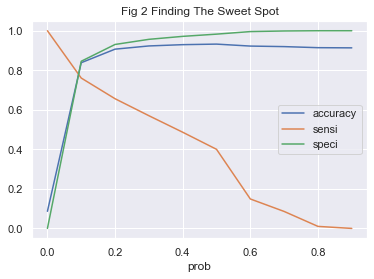

In [40]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.title('Fig 2 Finding The Sweet Spot')
plt.show()

So, we need to choose the threshold of 0.1

In [41]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[0.1] )
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

printmd('**Train Set Results**')
printmd('**Sensitivity, TPR or Recall {:.3f} %**'.format(100*TP/(TP+FN)))
printmd('**Specitivity {:.3f} %**'.format(100*TN/(TN+FP)))
printmd('**FPR {:.3f} %**'.format(100*FP/ float(TN+FP)))
printmd('**Precision {:.3f} %**'.format(100*TP/(TP+FP)))
printmd('**Accuracy {:.3f} %**'.format(100*(TP+TN)/(TP+FP+TN+FN)))

**Train Set Results**

**Sensitivity, TPR or Recall 76.066 %**

**Specitivity 84.567 %**

**FPR 15.433 %**

**Precision 31.834 %**

**Accuracy 83.831 %**

We now plot the ROC Curve

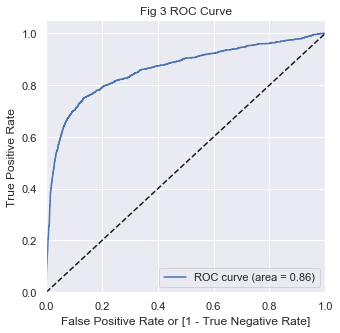

In [42]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Fig 3 ROC Curve')
    plt.legend(loc="lower right")
    
    plt.show()

    return None

fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

### 4.1 Logistic Regression Test Set Result

We have now established a baseline model with a Logistic Model. Let us test the model with the test set.

In [43]:
X_test_rfe=X_test[X_train_rfe.columns]
X_test_sm = sm.add_constant(X_test_rfe)
y_test_pred = log_reg.predict(X_test_sm)

y_test_pred_rfe = pd.DataFrame({'Converted':y_test.values, 'Conversion_Prob':y_test_pred})
y_test_pred_rfe['Predicted'] = y_test_pred_rfe.Conversion_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [44]:
confusion3 = metrics.confusion_matrix(y_test_pred_rfe.Converted, y_test_pred_rfe.Predicted )
TP = confusion3[1,1] # true positive 
TN = confusion3[0,0] # true negatives
FP = confusion3[0,1] # false positives
FN = confusion3[1,0] # false negatives

printmd('**Test Set Results**')
printmd('**Recall {:.3f} %**'.format(100*TP/(TP+FN)))
printmd('**Specitivity {:.3f} %**'.format(100*TN/(TN+FP)))
printmd('**FPR {:.3f} %**'.format(100*FP/(TN+FP)))
printmd('**Precision {:.3f} %**'.format(100*TP/(TP+FP)))
printmd('**Accuracy {:.3f} %**'.format(100*(TP+TN)/(TP+FP+TN+FN)))

# We Store These Results for comparison later
results1=[100*TP/(TP+FN),100*TN/(TN+FP),100*FP/(TN+FP),100*TP/(TP+FP),100*(TP+TN)/(TP+FP+TN+FN)]

**Test Set Results**

**Recall 77.987 %**

**Specitivity 84.296 %**

**FPR 15.704 %**

**Precision 31.714 %**

**Accuracy 83.756 %**

## 5. Ensemble Models

### 5.1 Random Forest on RFE Features

We now move on to a Random Forest Model. We use the same features that Logistic regression finally gave us after removing all multi-collinearity and retaining only significant p-values.  In order to arrive at the correct hyperparameters, we'll first establish the individual ranges for each hyperparameter. <br>

Our objective is to figure out a rough range for <br>

- max_depth
- min_samples_leaf
- min_samples_split
- n_estimators
- max_features

In [45]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

__Find the Optimum Max Depth__

In [78]:
param_grid = {'max_depth': range(1, 50,5)}
d_tree = DecisionTreeClassifier(criterion = "gini", class_weight='balanced', random_state = 100)

# We use the rfe X_train that wefinally got from Logistic Model
grid_max_depth = GridSearchCV(d_tree, param_grid,cv=5,scoring="recall",return_train_score=True)
grid_max_depth.fit(X_train_rfe,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 50, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='recall', verbose=0)

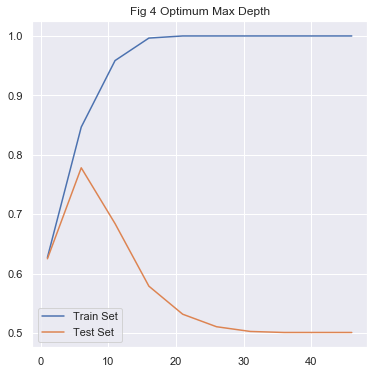

In [47]:
scores = grid_max_depth.cv_results_

fig4,ax4 = plt.subplots(1,1,figsize=(6,6))
ax4.set_title('Fig 4 Optimum Max Depth', fontsize=12)
ax4 = sns.lineplot(x="param_max_depth", y="mean_train_score", data=scores,label='Train Set')
ax4 = sns.lineplot(x="param_max_depth", y="mean_test_score", data=scores,label='Test Set')


Max Depth appears to be in the range of 5 to 10.

__Find the Optimum Min Samples Leaf__

In [48]:
param_grid = {'min_samples_leaf': range(100, 800,50)}
d_tree = DecisionTreeClassifier(criterion = "gini", class_weight='balanced', random_state = 100)

grid_min_samples_leaf = GridSearchCV(d_tree, param_grid,cv=5,scoring="recall",return_train_score=True)
grid_min_samples_leaf.fit(X_train_rfe,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': range(100, 800, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

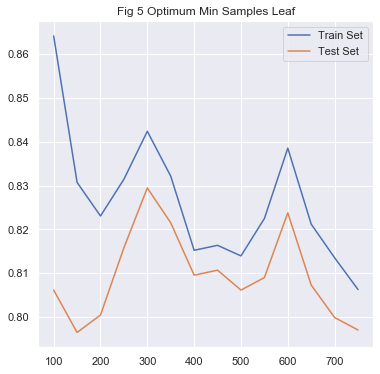

In [49]:
scores = grid_min_samples_leaf.cv_results_

fig5,ax5 = plt.subplots(1,1,figsize=(6,6))
ax5.set_title('Fig 5 Optimum Min Samples Leaf', fontsize=12)
ax5 = sns.lineplot(x="param_min_samples_leaf", y="mean_train_score", data=scores,label='Train Set')
ax5 = sns.lineplot(x="param_min_samples_leaf", y="mean_test_score", data=scores,label='Test Set')


Min Samples Leaf appears to be in the range of 250 to 350

__Find the Optimum Min Samples Split__

In [50]:
param_grid = {'min_samples_split': range(400, 900,50)}
d_tree = DecisionTreeClassifier(criterion = "gini", class_weight='balanced', random_state = 100)

grid_min_samples_split = GridSearchCV(d_tree, param_grid,cv=5,scoring="recall",return_train_score=True)
grid_min_samples_split.fit(X_train_rfe,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(400, 900, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)

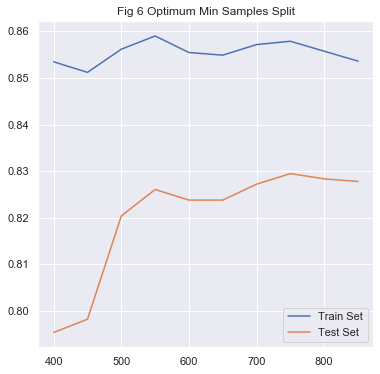

In [51]:
scores = grid_min_samples_split.cv_results_

fig6,ax6 = plt.subplots(1,1,figsize=(6,6))
ax6.set_title('Fig 6 Optimum Min Samples Split', fontsize=12)
ax6 = sns.lineplot(x="param_min_samples_split", y="mean_train_score", data=scores,label='Train Set')
ax6 = sns.lineplot(x="param_min_samples_split", y="mean_test_score", data=scores,label='Test Set')


Min Samples Split best setting appears to be within 700 to 800.

The reamining two features n_estimators and max_features we'll test in the final Grid Search. For __max_features__ we will use square root of the number of features. Since in the Logistic Regression final model , we had 16 features, we'll use 5as the mid point.

In [52]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [5,10,15],
    'min_samples_leaf': range(250, 300, 350),
    'min_samples_split': range(600, 700, 800),
    'n_estimators': [200,300,400], 
    'max_features': [3,5,10]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='recall',
                          cv = 3, n_jobs = -1,verbose = 1)

<span style="color:red">__CAUTION !!!__</span><br>
<span style="color:red">__The following grid-search in markdown-mode takes approximately 2-3 minutes to execute. Reader can skip the next cell to move to the tuned model or convert the following cell to code from markdown__</span>

grid_search.fit(X_train, y_train)

### printing the optimal recall score and hyperparameters

print('We can get Recall of',grid_search.best_score_,'using',grid_search.best_params_)

Now that , we've found the best settings, let us build our final model based on the optimum settings

In [53]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=250, 
                             min_samples_split=600,
                             max_features=10,
                             n_estimators=200,class_weight='balanced')

In [54]:
rfc.fit(X_train_rfe,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=10,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=250,
            min_samples_split=600, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [55]:
y_pred = rfc.predict(X_test[X_train_rfe.columns])
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7966
           1       0.32      0.83      0.46       745

   micro avg       0.83      0.83      0.83      8711
   macro avg       0.65      0.83      0.68      8711
weighted avg       0.92      0.83      0.86      8711



In [56]:
confusion_rf = metrics.confusion_matrix(y_test,y_pred)

In [57]:
TP = confusion_rf[1,1] # true positive 
TN = confusion_rf[0,0] # true negatives
FP = confusion_rf[0,1] # false positives
FN = confusion_rf[1,0] # false negatives

printmd('**Test Set Results**')
printmd('**Sensitivity, TPR or Recall {:.3f} %**'.format(100*TP/(TP+FN)))
printmd('**Specitivity {:.3f} %**'.format(100*TN/(TN+FP)))
printmd('**FPR {:.3f} %**'.format(100*FP/ float(TN+FP)))
printmd('**Precision {:.3f} %**'.format(100*TP/(TP+FP)))
printmd('**Accuracy {:.3f} %**'.format(100*(TP+TN)/(TP+FP+TN+FN)))

# We Store These Results for comparison later
results2=[100*TP/(TP+FN),100*TN/(TN+FP),100*FP/(TN+FP),100*TP/(TP+FP),100*(TP+TN)/(TP+FP+TN+FN)]

**Test Set Results**

**Sensitivity, TPR or Recall 82.819 %**

**Specitivity 83.241 %**

**FPR 16.759 %**

**Precision 31.609 %**

**Accuracy 83.205 %**

### 5.2 Random Forest on Entire Feature Set

Before we proceed to the next Ensemble Model, let us try the Random Forest Model with the entire set of derived features and hyperparameters deduced above.

In [58]:
rfc_full_set= RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=250, 
                             min_samples_split=600,
                             max_features=10,
                             n_estimators=200,class_weight='balanced')
rfc_full_set.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=10,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=250,
            min_samples_split=600, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [59]:
y_pred_full_set = rfc_full_set.predict(X_test)

In [60]:
confusion_rf_full_set = metrics.confusion_matrix(y_test,y_pred_full_set)
TP = confusion_rf_full_set[1,1] # true positive 
TN = confusion_rf_full_set[0,0] # true negatives
FP = confusion_rf_full_set[0,1] # false positives
FN = confusion_rf_full_set[1,0] # false negatives

printmd('**Test Set Results**')
printmd('**Sensitivity, TPR or Recall {:.3f} %**'.format(100*TP/(TP+FN)))
printmd('**Specitivity {:.3f} %**'.format(100*TN/(TN+FP)))
printmd('**FPR {:.3f} %**'.format(100*FP/ float(TN+FP)))
printmd('**Precision {:.3f} %**'.format(100*TP/(TP+FP)))
printmd('**Accuracy {:.3f} %**'.format(100*(TP+TN)/(TP+FP+TN+FN)))

# We Store These Results for comparison later
results3=[100*TP/(TP+FN),100*TN/(TN+FP),100*FP/(TN+FP),100*TP/(TP+FP),100*(TP+TN)/(TP+FP+TN+FN)]

**Test Set Results**

**Sensitivity, TPR or Recall 83.624 %**

**Specitivity 84.785 %**

**FPR 15.215 %**

**Precision 33.951 %**

**Accuracy 84.686 %**

__Slight Improvement in Recall and accuracy__

### 5.3 Summarizing The Results So Far

We have three models as of now. Let us see, how far we've come !!

In [61]:
Compare=pd.DataFrame({'Metric':['Recall', 'Specificity', 'FPR','Precision','Accuracy'],
                   'Logistic RFE':results1, 'Random Forest RFE':results2,
                   'Random Forest All Features':results3})
Compare

,Metric,Logistic RFE,Random Forest RFE,Random Forest All Features
0,Recall,77.986577,82.818792,83.624161
1,Specificity,84.295757,83.241275,84.785338
2,FPR,15.704243,16.758725,15.214662
3,Precision,31.713974,31.608607,33.950954
4,Accuracy,83.756170,83.205143,84.686029


Random Forest with all 31 features is performing the best. Looking at the business problem, our main agenda is to push Recall Higher. We'll build the next ensemble model based on these findings.<br>

Let us see , what are the most important features declared by Random Forest.  

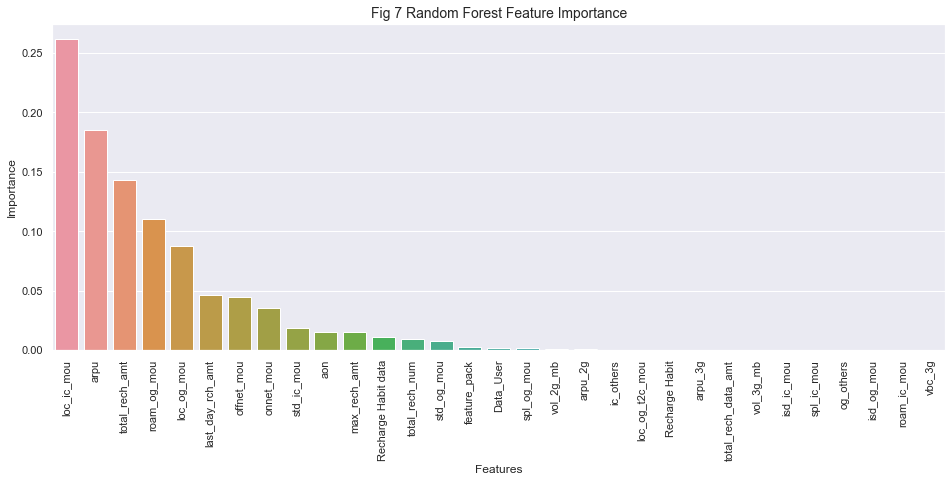

In [62]:
my_features=pd.DataFrame({'Features':X_train.columns,'Importance':rfc_full_set.feature_importances_})
my_features.sort_values(by='Importance',ascending=False,inplace=True)

fig7,ax7 = plt.subplots(1,1,figsize=(16,6))
ax7.set_title('Fig 7 Random Forest Feature Importance', fontsize=14)
ax7 = sns.barplot(x="Features", y="Importance", data=my_features)
for tick in ax7.get_xticklabels():
    tick.set_rotation(90)

## 6. Ensemble Model - Gradient Boost

We skip __Adaboost__ and move straight to __Gradient Boost__. We use the top __15 Features__ as depicted in Figure 7 above and putting it in the list called final_features.

In [63]:
# Selecting the top 15 features from the Random Forest Algorithm Above

final_features=list(my_features.iloc[0:15,0])
rfe_features=X_train_rfe.columns

### 6.1 Handling Class Imbalance in GBoost

One caveat is the feature imbalance in the dataset. We saw earlier that, barely 9-10% cases are Churns. We were able to handle this anomaly by using __class_weight='balanced'__ in our ealier classifiers.<br>

The GB Classifier has no such option. Some research led the authors [here](https://www.kaggle.com/zksharp48/fraud-detection-gradient-boosting-oversampling/notebook) ,a kaggle project explaining oversampling using a library __imblearn__. <br>

<span style="color:red">__The following section mandates imblearn installation, otherwise the subsequent sections would fail to execute__</span>

In [64]:
# Please install imblearn !!

from imblearn.over_sampling import SMOTE
# Apply SMOTE's
kind = 'regular'
smt = SMOTE(kind='regular')

# We generate a synthetic dataset using oversampling
X_res, y_res = smt.fit_sample(X_train[final_features], y_train)
X_res=pd.DataFrame(X_res,columns=[final_features])
print("Sampled Dataset has shape: ", X_res.shape)
print("Number of Churn Cases (Real && Synthetic): ", np.sum(y_res))

Sampled Dataset has shape:  (37128, 15)
Number of Churn Cases (Real && Synthetic):  18564


In [65]:
X_train_res,X_test_res,y_train_res,y_test_res=train_test_split(X_res,y_res,train_size=0.7,random_state=100)

### 6.2 Hyperparameters for GBoost

The following cell sets up the GridSearch set up for Gradient Boost.

In [66]:
gb_grid_params = {'learning_rate': [0.02,0.05, 0.1],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20, 50,100],
              'max_features': ['auto','log2'] 
              }

skv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False)


gb_gs = GradientBoostingClassifier(n_estimators = 600)
gb_clf = GridSearchCV(gb_gs,gb_grid_params,cv=skv.split(X_res, y_res),
                      scoring='recall',verbose = 1,n_jobs=10,return_train_score=True)

<span style="color:red">__CAUTION !!!__</span>

<span style="color:red">__!!! The GradientBoost Grid search step in the cell below takes 60 minutes. The reader can skip this step to move to the model with tuned hyperparameters or convert the following cell to code from markdown !!!__</span>

gb_clf.fit(X_res, y_res)

print('We can get Recall of',gb_clf.best_score_,'using',gb_clf.best_params_)

### 6.3 Running the Tuned GBoost Model

Now that, we've the optimum parameters for GBoost, we'll fit a model to  the oversampled dataset __X_train_res / y_train_res__ <br>

Once the model is fit, we will attempt prediction on our original dataset with 15 features.

In [67]:
# Build the model with the optimum Hyperparameters, but on the oversampled dataset X_train_res, y_train_res

gboost_final = GradientBoostingClassifier(n_estimators = 600,learning_rate=0.1,max_depth=8,min_samples_leaf=20,max_features= 'log2')
gboost_final.fit(X_res, y_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [68]:
# Run prediction on the test set, that is NOT oversampled ( the actual test set ) with top 15 features

y_pred_gb = gboost_final.predict(X_test[final_features])

In [69]:
confusion_gboost = metrics.confusion_matrix(y_test,y_pred_gb)
TP = confusion_gboost[1,1] # true positive 
TN = confusion_gboost[0,0] # true negatives
FP = confusion_gboost[0,1] # false positives
FN = confusion_gboost[1,0] # false negatives

printmd('**Test Set Results**')
printmd('**Sensitivity, TPR or Recall {:.3f} %**'.format(100*TP/(TP+FN)))
printmd('**Specitivity {:.3f} %**'.format(100*TN/(TN+FP)))
printmd('**FPR {:.3f} %**'.format(100*FP/ float(TN+FP)))
printmd('**Precision {:.3f} %**'.format(100*TP/(TP+FP)))
printmd('**Accuracy {:.3f} %**'.format(100*(TP+TN)/(TP+FP+TN+FN)))

# We Store These Results for comparison later
results4=[100*TP/(TP+FN),100*TN/(TN+FP),100*FP/(TN+FP),100*TP/(TP+FP),100*(TP+TN)/(TP+FP+TN+FN)]

**Test Set Results**

**Sensitivity, TPR or Recall 57.450 %**

**Specitivity 95.983 %**

**FPR 4.017 %**

**Precision 57.219 %**

**Accuracy 92.687 %**

## 7. Ensemble Model - XG Boost

This is our final model. We deal with data imbalance using two techniques.<br>

- We use __RandmizedSearchCV__ and __StratifiedKFold__
- We set scale_pos_weight=10 in the model, as that represents the ratio of the positive to negative class ratio.

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [71]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5,8]
        }

# Note that we've used RandmizedSearchCV and StratifiedKFold for finding the optimum parameters.
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, 
                    objective='binary:logistic',silent=True, nthread=1,scale_pos_weight=10)

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='recall',
                                   n_jobs=4, cv=skf.split(X_train[final_features], y_train), verbose=3, random_state=1001 )


<span style="color:red">__CAUTION !!!__</span>

<span style="color:red">__!!! The XGBoost Grid search step in the cell below takes 3 minutes. The reader can skip this step to move to the model with tuned hyperparameters or or convert the following cell to code from markdown !!!__</span>

### Please set the cell to code for execution

random_search.fit(X_train[final_features], y_train)
print('We can get Recall of',random_search.best_score_,'using',random_search.best_params_)

In [72]:
# Running XGBoost with the optimum parameters

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1,subsample=1, min_child_weight=5, max_depth= 4,
                    gamma= 5, colsample_bytree= 1,scale_pos_weight=10)

xgb.fit(X_train[final_features], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=5, learning_rate=0.02,
       max_delta_step=0, max_depth=4, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
       seed=None, silent=True, subsample=1, verbosity=1)

In [73]:
y_pred_xg=xgb.predict(X_test[final_features])

confusion_xgboost = metrics.confusion_matrix(y_test,y_pred_xg)
TP = confusion_xgboost[1,1] # true positive 
TN = confusion_xgboost[0,0] # true negatives
FP = confusion_xgboost[0,1] # false positives
FN = confusion_xgboost[1,0] # false negatives

printmd('**Test Set Results**')
printmd('**Sensitivity, TPR or Recall {:.3f} %**'.format(100*TP/(TP+FN)))
printmd('**Specitivity {:.3f} %**'.format(100*TN/(TN+FP)))
printmd('**FPR {:.3f} %**'.format(100*FP/ float(TN+FP)))
printmd('**Precision {:.3f} %**'.format(100*TP/(TP+FP)))
printmd('**Accuracy {:.3f} %**'.format(100*(TP+TN)/(TP+FP+TN+FN)))

# We Store These Results for comparison later
results5=[100*TP/(TP+FN),100*TN/(TN+FP),100*FP/(TN+FP),100*TP/(TP+FP),100*(TP+TN)/(TP+FP+TN+FN)]

**Test Set Results**

**Sensitivity, TPR or Recall 80.403 %**

**Specitivity 88.978 %**

**FPR 11.022 %**

**Precision 40.555 %**

**Accuracy 88.245 %**

## 7. Model Comparison

We have now four models 

- __log_reg__ : Baseline Logistic Regression with 14 Features after removing Multi-collinearity and insignifcant features.
- __rfc__ : Random Forest Model with the same set of features as above.
- __rfc_full_set__ : Random Forest with full set of derived features.
- __gboost_final__ : Gradient Boost Model with top 15 features identified by __rfc_full_set__.
- __xgb__ : Gradient Boost Model with top 15 features identified by __rfc_full_set__.

We'll first their performance on test sets, followed by ROC Curves on all 4 models. We expect to see __xgboost__ overshadowing the other models.

In [74]:
printmd('**Test Set Results**')

Compare['GBoost with Top 15 Features']=results4
Compare['XGBoost with Top 15 Features']=results5
Compare

**Test Set Results**

,Metric,Logistic RFE,Random Forest RFE,Random Forest All Features,GBoost with Top 15 Features,XGBoost with Top 15 Features
0,Recall,77.986577,82.818792,83.624161,57.449664,80.402685
1,Specificity,84.295757,83.241275,84.785338,95.982927,88.978157
2,FPR,15.704243,16.758725,15.214662,4.017073,11.021843
3,Precision,31.713974,31.608607,33.950954,57.219251,40.555179
4,Accuracy,83.756170,83.205143,84.686029,92.687407,88.244748


### 7.1 The ROC curves

We can also comapre the overall perfromance of the model using the ROC Curves and reading the AUC for each model

In [75]:
# We'd require the predicted probabilities for each model.

log_reg_proba = log_reg.predict(X_test_sm)
rfc_proba=rfc.predict_proba(X_test[X_train_rfe.columns])[:, 1]
rfc_full_set_proba=rfc_full_set.predict_proba(X_test)[:, 1]
gboost_final_proba=gboost_final.predict_proba(X_test[final_features])[:, 1]
xgboost_final_proba=xgb.predict_proba(X_test[final_features])[:, 1]

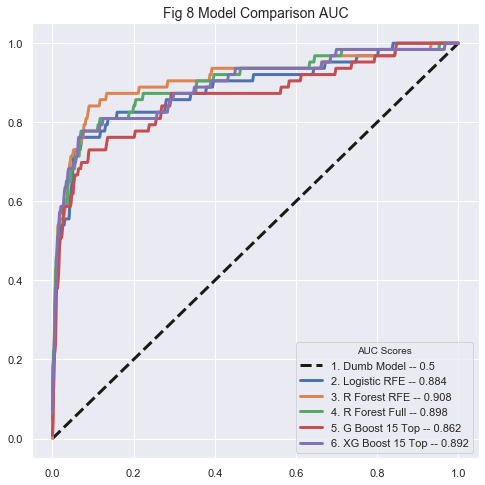

In [76]:
fig8,ax8 = plt.subplots(1,1,figsize=(8,8))
ax8.set_title('Fig 8 Model Comparison AUC', fontsize=14)

# We use this function to deduce fpr,tpr, auc_score for all models
def draw_roc2( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    
    return fpr,tpr,round(auc_score,3)

ax8 = sns.lineplot(x=[0,1], y=[0,1],label='1. Dumb Model -- 0.5',linewidth= 3,color='k')
ax8.lines[0].set_linestyle("--")

fpr,tpr,auc_score=draw_roc2(y_test[0::10],log_reg_proba[0::10])
ax8 = sns.lineplot(x=fpr, y=tpr,label='2. Logistic RFE -- {:.3f}'.format(auc_score),linewidth= 3)

fpr,tpr,auc_score=draw_roc2(y_test[0::10],rfc_proba[0::10])
ax8 = sns.lineplot(x=fpr, y=tpr,label='3. R Forest RFE -- {:.3f}'.format(auc_score),linewidth= 3)

fpr,tpr,auc_score=draw_roc2(y_test[0::10],rfc_full_set_proba[0::10])
ax8 = sns.lineplot(x=fpr, y=tpr,label='4. R Forest Full -- {:.3f}'.format(auc_score),linewidth= 3)

fpr,tpr,auc_score=draw_roc2(y_test[0::10],gboost_final_proba[0::10])
ax8 = sns.lineplot(x=fpr, y=tpr,label='5. G Boost 15 Top -- {:.3f}'.format(auc_score),linewidth= 3)

fpr,tpr,auc_score=draw_roc2(y_test[0::10],xgboost_final_proba[0::10])
ax8 = sns.lineplot(x=fpr, y=tpr,label='6. XG Boost 15 Top -- {:.3f}'.format(auc_score),linewidth= 3)

ax8.legend().set_title('AUC Scores')


We can strightaway pan the model __5.G Boost 15 Top__, as it has the lowest AUC and its Recall is merely 57%. This'll practically serve no purpose to capture potential churners.<br>

Though, the maximum AUC=0.907 is registered for __3.Random Forest RFE Features__, but we've every reason to stick to  __6.XGBoost with Top 15 Features__ model. This is because , it has the lowest __FPR=11%__ and it has __Recall=80.4%__. This is only slightly worse than the __Random Forest All Features__ model, which has __Recall=84%__ but __FPR=54%__.

## 8. Business Insights

Now that, we've chosen XGBoost with Top 15 Features as our final model, let us try to understand how these 15 features actually indicate a potential churner.

In [77]:
from ipywidgets import *
n=len(final_features)-1

printmd('***Use the Widget Below***')

def h(x):
    
    fig9,ax9 = plt.subplots(1,1,figsize=(4, 4))
    col=final_features[x]
    
    sns.boxplot(x=y, y=X[col], data=X,ax=ax9,linewidth=0.5,width=0.5)
    ax9.set_title('Fig 9 {}'.format(col), fontsize=14)
    return None

interact(h, x=widgets.IntSlider(min=0, max=n, step=1, value=0));


***Use the Widget Below***

interactive(children=(IntSlider(value=0, description='x', max=14), Output()), _dom_classes=('widget-interact',…

Please recall, most features have been converted to a fraction representing change in Aug , relative to mean of Jun and July. One such example is presented here again.

For Example <br>
$ xi = mean ( onnet\_mou\_6,onnet\_mou\_7) $ <br>
$ xf = onnet\_mou\_8 $ <br>
$ delta = xf - xi $ <br>
$ onnet\_mou = \frac { delta } {xi} $ <br>


From the sliding widget above, we can see that except __roam_og_mou__ and __feature_pack__ all others show a clear tendency towards churn, if there is huge reduction in them in Month 8 compared to mean of month 6 and 7. Thus, from a business perspective , if there is a sharp decline in the __action_phase__.<br>

- __Local,STD Incoming Minutes of Usage:__ It seems, if there's a sharp decline , it most probably indicates that the subscriber has moved to a new number and has shared the new number to his contacts.
- __Local, STD, Roaming Outgoing Minutes of Usage:__ Similarly, if the user has started using another operator, there's no reason why he would keep making outgoing calls.
- __Onnet-Offnet Minutes of Usage:__ A decline in above factors will obviously affect the Onnet/Offnet Usage. This is just a euphemism for saying that the subscriber has stopped using the current number.
- __ARPU:__ This is relatively simple to understand. The subscriber stopping revenue generating activity is a clear indication of him not using the services.
- __Total, Maximum Recharge and Last Date recharge Amount :__ If a subscriber carries on his usual usage pattern, there is no reason for a sharp decline here in the action phase. However, if he his recharge pattern shows a sharp decline, its a caue of concern.
- __Age on Network ( AON ):__ It seems that new users are more prone to changing the service provider. This is probably because , old users find it harder to update their contacts. That's why their stickiness is higher. __This is a big insight, indicating that new users must be made to stick to their current number__ for a certain period to ensure their loyalty. That probably explains operators giving away free Amazon Prime/ Netflix services for new users.
- __Recahrge Habit Data:__ Please recall,  this fetaure is sum of thre weights 1,2 and 3. If a subscriber recharges all three months, this will be 1+2+3=6. Whereas, if he recharges in only Jun and July, then it would be 1+2+0=5. A figure less than 2 indicates that he hasn't recharges even once in Aug. This is an indicator of the fact, that the subscriber has probably lost interest.